# Imports and file loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import imageio
from scipy.ndimage.interpolation import rotate
from math import cos, sin
import time
import random
import string
import optical_imaging as oi
pi=3.14159

In [2]:
file_directory='/home/preston/Desktop/Science/Research/cancer_cells/data/first_polystyrene_imaging/'
file_name='microbeads_2.mp4'
vid = oi.open_video_connection(file_directory+file_name)
template_frame = oi.get_frame(vid, 0)
frame = oi.get_frame(vid, 1800)

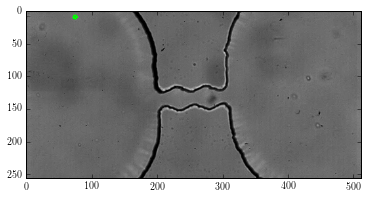

In [3]:
clusters=oi.find_clusters(frame, template_frame)
oi.plot_highlighted_frame(frame, clusters)

# Clustering

## Define cluster class

In [9]:
class cluster:
    def __init__(self, frame, pixels):
        
        # Define variables
        identity=random.choice(string.letters)
        
        self._trajectory=np.zeros((0,7))
        t=frame
        
        x_0=pixels[:,1].min()
        x_1=pixels[:,1].max()
        y_0=pixels[:,0].min()
        y_1=pixels[:,0].max()
        
        x = int((x_1+x_0)/2.)
        y = int((y_1+y_0)/2.)
        
        vx=0
        vy=0
            
        w = x_1-x_0
        h = y_1-y_0

        # Initialize instance variables
        self._pixels=[pixels]
        self._identity=identity
        self._t=[t]
        self._x=[x]
        self._y=[y]
        self._vx=[vx]
        self._vy=[vy]
        self._w=[w]
        self._h=[h]
        self._x_pred=self._x[-1]
        self._y_pred=self._y[-1]
        
    def update_predicted_position(self, frame):        
        self._x_pred=self._x[-1]+self._vx[-1]*(frame-self._t[-1])
        self._y_pred=self._y[-1]+self._vy[-1]*(frame-self._t[-1])
        
        return
    
    def update_trajectory(self, cluster):       
        self._pixels.append(cluster._pixels)
        self._t.append(cluster._t[-1])
        self._x.append(cluster._x[-1])
        self._y.append(cluster._y[-1])
        
        self._vx.append(1.*(self._x[-1]-self._x[-2])/(self._t[-1]-self._t[-2]))
        self._vy.append(1.*(self._y[-1]-self._y[-2])/(self._t[-1]-self._t[-2]))
        
        self._w.append(cluster._w[-1])
        self._h.append(cluster._h[-1])
        
        return

## Cluster finding algorithm

In [10]:
def find_clusters(negative_image, frame, threshold_difference=10, cluster_threshold=5):
    cluster_list=[]
    pixel_check_array=np.ones((negative_image.shape[0], negative_image.shape[1]))
    for i in range(pixel_check_array.shape[0]):
        for j in range(pixel_check_array.shape[1]):
            if pixel_check_array[i,j]==1:
                if negative_image[i,j] >= threshold_difference:
                    cluster_pixels, pixel_check_array=add_pixel_to_cluster\
                    (negative_image, pixel_check_array, i, j, threshold_difference)
                    
                    if cluster_pixels.shape[0]>cluster_threshold:
                        new_cluster=cluster(frame, cluster_pixels)
                        cluster_list.append(new_cluster)
    
    return cluster_list

In [11]:
def add_pixel_to_cluster(image, pixel_check_array, i, j, threshold, cluster_pixels=np.empty((0,2), dtype=int), direction='center'):
    
    cluster_pixels=np.vstack((cluster_pixels,[i,j]))
    pixel_check_array[i,j]=0
    
    # Center (first point)
    if direction == 'center':
        pixel_check_array[i,j]=0
        
    # Right
    if direction != 'right' and j != image.shape[1] -1 and pixel_check_array[i,j+1] == 1:
        if image[i,j+1]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i, j+1, threshold, cluster_pixels, 'left')

    # Below
    if direction != 'below' and i != image.shape[0] - 1 and pixel_check_array[i+1,j] == 1:
        if image[i+1,j]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i+1, j, threshold, cluster_pixels, 'above')   
        
    # Left
    if direction != 'left' and j != 0 and pixel_check_array[i,j-1] == 1:
        if image[i,j-1]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i, j-1, threshold, cluster_pixels, 'right')

    # Above
    if direction != 'above' and i != 0 and pixel_check_array[i-1,j] == 1:
        if image[i-1,j]>=threshold:
            cluster_pixels, pixel_check_array=add_pixel_to_cluster(image, pixel_check_array, i-1, j, threshold, cluster_pixels, 'below')

    return cluster_pixels, pixel_check_array

## Cluster tracking algorithm

In [12]:
x_thresh=500
d_thresh=10

In [13]:
def match_clusters(currently_tracking, just_tracked, previously_tracked, frame):
    
    new_currently_tracking=[]
    
    # Update currently_tracking particles' predicted positions
    for j in range(len(currently_tracking)):
        currently_tracking[j].update_predicted_position(frame)
    
    # Create, fill distance matrix
    distance_matrix=np.zeros((len(just_tracked)+1, len(currently_tracking)+1))
    

    for i in range(distance_matrix.shape[0]):
        distance_matrix[i,0]=i-1
    for j in range(distance_matrix.shape[1]):
        distance_matrix[0,j]=j-1
    
    for i in range(1,len(just_tracked)+1): # just_tracked
        for j in range(1,len(currently_tracking)+1): # currently_tracking
            xi=just_tracked[i-1]._x[-1]
            yi=just_tracked[i-1]._y[-1]
            xj=currently_tracking[j-1]._x_pred
            yj=currently_tracking[j-1]._y_pred
            distance_matrix[i,j]=((xi-xj)**2.+(yi-yj)**2.)**.5
            
            
    # Match columns to row
    check_rows=[i for i in range(0,len(just_tracked))]
    for j in range(len(currently_tracking)):
        # Get index of row with minimum distance
        if check_rows != []:# > 1:
            temp_min_row=np.argmin(distance_matrix[[row+1 for row in check_rows], j+1],0)
            min_row=int(distance_matrix[[row+1 for row in check_rows],[0]][temp_min_row])
            
            # Check to see if point still good (i.e., if the minimum makes sense)
            if currently_tracking[j]._x_pred > x_thresh and distance_matrix[min_row+1, j+1] >= d_thresh:
                min_row = None
            
        else:
            min_row=None
        
        
        # Correct match found
        if min_row != None:
            # Remove row from check list
            check_rows=[row for row in check_rows if row != min_row]
        
            # Update the particle that is being tracked with the matched particle
            currently_tracking[j].update_trajectory(just_tracked[min_row])
            
            # Add the particle to new_currently_tracking list
            new_currently_tracking.append(currently_tracking[j])
            
        # No match found
        else:
            previously_tracked.append(currently_tracking[j])
            
        
    # Add rows that did not match to new_currently_tracking
    for row in check_rows:
        new_currently_tracking.append(just_tracked[row])
        
    #print distance_matrix
        
    return new_currently_tracking

# Open video connection

In [14]:
vid = imageio.get_reader(file_directory+file_name,  'ffmpeg')
num_frames=vid._meta['nframes']
print num_frames

16224


# Image processing

In [15]:
def preprocess_image(image):
    #ystart=50
    #yend=225
    #xstart=150
    #xend=350
    #image=rotate(image[ystart:yend, xstart:xend,:], theta, axes=(1,0), reshape=False)
    #image=image[40:130, 25:180,:]
    return image

In [16]:
def get_negative_image(image, templage_image):
    negative_image=np.empty((image.shape[0], image.shape[1]), dtype=int)
    for i in range(negative_image.shape[0]):
        for j in range(negative_image.shape[1]):
            negative_image[i,j]=abs(int(image[i,j,0])-int(template_image[i,j,0]))
    return negative_image

In [17]:
def highlight_cluster_pixels(image, cluster_pixels):
    for i in range(cluster_pixels.shape[0]):
        x=cluster_pixels[i,0]
        y=cluster_pixels[i,1]
        image[x,y,0]=0#image[x,y,0]/10.
        image[x,y,1]=255.#image[x,y,1]*4.
        image[x,y,2]=0#image[x,y,2]/10.
    return image

# Define template image

In [18]:
def get_pore_coordinates(x, y):
    new_x=(x-xp)*pore_length/pore_plength
    new_y=(y-yp)*pore_width/pore_pwidth
    return new_x, new_y

In [19]:
theta=-3.35
buff=25

pore_pwidth=20.
pore_length=125.
pore_width=25.
pore_plength=107.

xp=25
yp=43

In [20]:
template_frame=0
template_image=vid.get_data(template_frame)
template_image=preprocess_image(template_image)

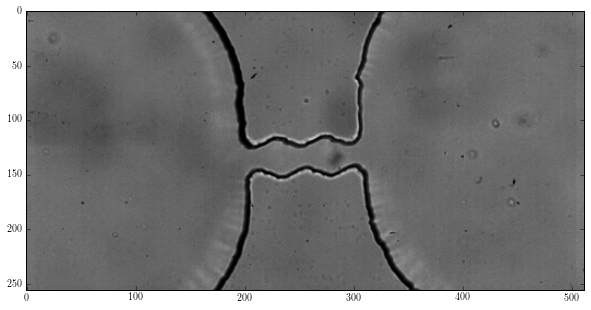

In [21]:
fig=plt.figure(figsize=(10,6))
plt.imshow(template_image)
#plt.scatter(xp,yp, s=100, zorder=10, marker='x', c=(1.,0.,0.), lw=5)
#plt.plot([xp,xp],[0,1000],lw=3,c=(1.,1.,1.))
#plt.plot([xp+pore_plength,xp+pore_plength],[0,1000],lw=3,c=(1.,1.,1.))
#plt.plot([0,1000],[yp+pore_pwidth/2,yp+pore_pwidth/2],lw=3,c=(1.,1.,1.))
#plt.plot([0,1000],[yp-pore_pwidth/2,yp-pore_pwidth/2],lw=3,c=(1.,1.,1.))

#plt.xlim(0,template_image.shape[1]-1)
#plt.ylim(template_image.shape[0]-1,0)
plt.show()

# Analysis

## Get first frame with particle (test thresholding)

510


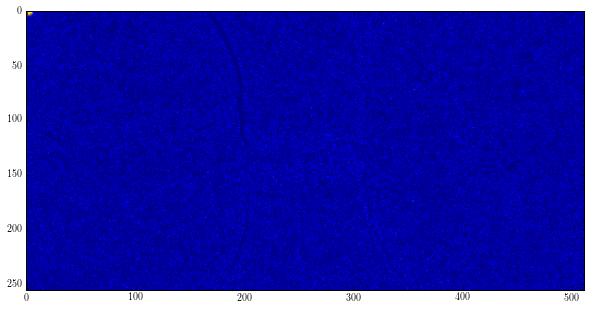

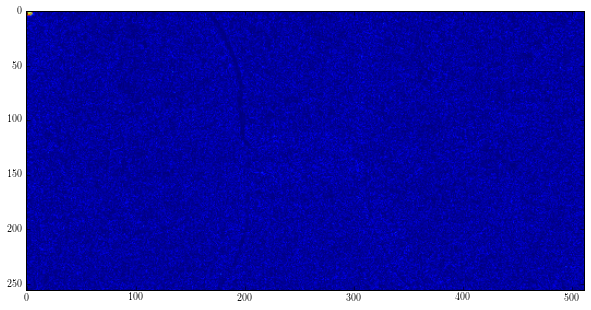

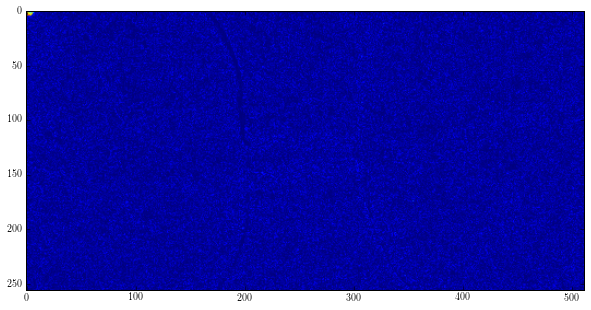

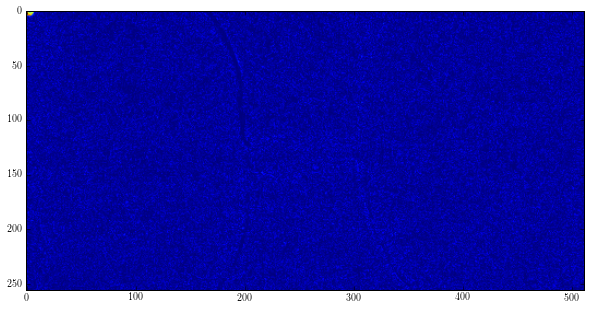

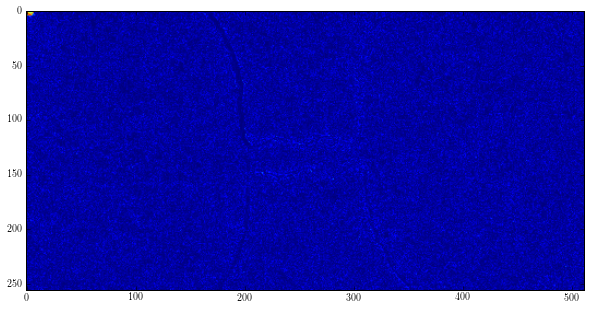

In [24]:
# Search parameters
start_frame=0
end_frame=num_frames
frame_skip=10
threshold_difference=25
cluster_threshold=20
num_frames_plot=5
frame_plot_skip=5


# Begin search
cluster_found = False
frame=start_frame
while cluster_found == False:
    if (frame+1)%100==0:
        print frame
    
    image=vid.get_data(frame)
    frame+=frame_skip
    
    negative_image=get_negative_image(image, template_image)
    new_cluster_list=find_clusters(negative_image, frame, threshold_difference=threshold_difference,\
                                   cluster_threshold=cluster_threshold)
    clusters_found = len(new_cluster_list)
    
    # Particle found; plot
    if clusters_found > 0:
        cluster_found = True
        
        print frame
        for j in range(num_frames_plot):
            image=vid.get_data(frame)
            negative_image=get_negative_image(image, template_image)
            new_cluster_list=find_clusters(negative_image, frame, threshold_difference=threshold_difference,\
                                           cluster_threshold=cluster_threshold)
            clusters_found = len(new_cluster_list)
            for i in range(len(new_cluster_list)):
                image=highlight_cluster_pixels(image, new_cluster_list[i]._pixels[-1])
            
            fig=plt.figure(figsize=(10,6))
            plt.imshow(image)
            plt.show()
            frame+=frame_plot_skip
        

## Create video

In [17]:
def get_frame(frame):
    # Preprocessing
    image=vid.get_data(frame)
    image=preprocess_image(image)
    negative_image=get_negative_image(image, template_image)
    
    # Find clusters
    new_cluster_list=get_clusters(negative_image)
    clusters_found=len(new_cluster_list)
    
    # Highlight clusters
    for i in range(len(new_cluster_list)):
        image=highlight_cluster_pixels(image,new_cluster_list[i]._cluster_pixels)
    
    # Set cluster text
    for i in range(clusters_found):
        cluster=new_cluster_list[i]
        text='('+str(cluster._wp)+', '+str(cluster._hp)+')'\
        +'\n'+'('+str(round(cluster._xP,2))+', '+str(round(cluster._yP,2))+')'
        particle_text_list[clusters_found-1].set_text(text)
        particle_text_list[clusters_found-1].set_x(cluster._xp)
        particle_text_list[clusters_found-1].set_y(cluster._yp)
                   
    # Remove text from non-visible clusters
    for i in range(clusters_found, len(particle_text_list)):
        particle_text_list[i].set_visible(False)
    
    # Set time text
    time_text.set_text(str(frame)+'/'+str(num_frames))
    
    # Set image array data
    im.set_array(image)
    
    return im, time_text, particle_text_list[0], particle_text_list[1], particle_text_list[2], particle_text_list[3],\
particle_text_list[4]

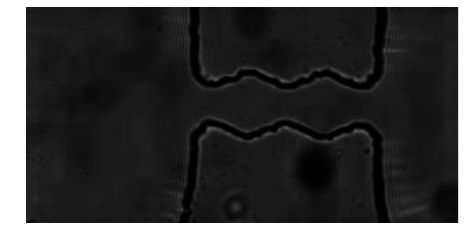

In [18]:
time_text_size=16
cluster_text_size=12

fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax = plt.axes(xlim=(0, template_image.shape[1]), ylim=(0, template_image.shape[0]))
im = plt.imshow(template_image)
plt.axis('off')

time_text=ax.text(template_image.shape[1]/2,10,'', size=time_text_size, ha='center')
particle_text_list=[ax.text(0,0,'', size=cluster_text_size, va='center') for i in range(5)]

def init():
    im.set_data(template_image)
    time_text.set_text('')
    return im, time_text

In [19]:
plt.rcParams['animation.ffmpeg_path']=ffmpeg_bin
anim = animation.FuncAnimation(fig, get_frame, np.arange(0, num_frames, 1), init_func=init, interval=100, blit=True)
writer=animation.FFMpegWriter()
output_file_name='./'+file_name.split('.')[0]+'_tracking.mp4'
anim.save(output_file_name, writer=writer, fps=60)

NameError: global name 'get_clusters' is not defined

# Particle tracking

In [20]:
previously_tracked=[]
currently_tracking=[]
particle_frames=[]

#################
start=time.time()
#################

# Begin loop
start_frame=0
end_frame=num_frames
frame_skip=1
threshold_difference=25
cluster_threshold=20
for frame in np.arange(start_frame,end_frame,frame_skip):
    
    if frame%100==0:
        print frame
    
    # Open, preprocess image data
    image=vid.get_data(frame)
    #image=preprocess_image(image)
    negative_image=get_negative_image(image, template_image)
    
    # Get just tracked clusters
    just_tracked = find_clusters(negative_image, frame, threshold_difference=threshold_difference, cluster_threshold=cluster_threshold)
    
    # Match currently_tracking clusters to just_tracked clusters, and update clusters with new positions, velocities
    currently_tracking = match_clusters(currently_tracking, just_tracked, previously_tracked, frame)
    
###############
end=time.time()
print 'time elapsed = ', end-start
print 'particles found: ', len(previously_tracked)
###############

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
time elapsed =  406.493273973
particles found:  170


# Plot trajectories

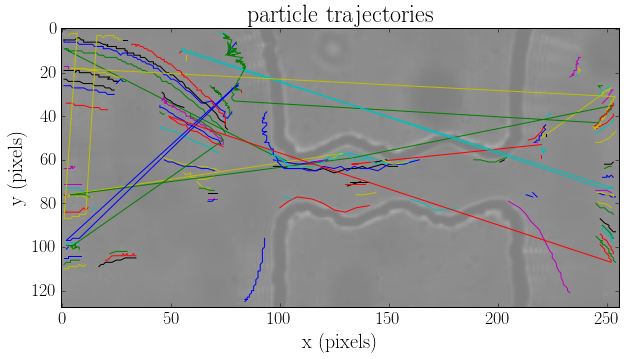

In [21]:
fig=plt.figure(figsize=(10,8))
for cluster in previously_tracked:
    plt.plot(cluster._x, cluster._y, label=cluster._identity)

plt.title('particle trajectories', size = 24)

plt.tick_params(labelsize=18)
plt.xlabel('x (pixels)', size=20)
plt.ylabel('y (pixels)', size=20)
plt.imshow(template_image, alpha=0.5)
#plt.xlim(0,510)
#plt.ylim(0,225)
#plt.legend()
plt.savefig('./particle_trajectories.png', dpi=300)
plt.show()

# Large video

## Resistive pulse analysis

In [ ]:
resistive_pulse_directory='/home/preston/Desktop/Science/Research/cancer_cells/data/7-4-2016/'
resistive_pulse_file='mix_0005.atf'